In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyswarm import pso
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# Load the dataset (adjust the file path as needed)
file_path = 'Main Dataset.xlsx'



data = pd.read_excel(file_path, skiprows=2, index_col=0)

# Calculate monthly returns
returns = data.pct_change().dropna()

# Compute mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()


In [3]:
# 2. Define the Objective Function for PSO (Negative Sharpe Ratio)
def sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe  # Negative because PSO minimizes

# 3. Set Cardinality Constraint Function
def cardinality_constraint(weights):
    # Cardinality constraint - how many non-zero weights are allowed
    return max_assets - np.count_nonzero(weights)

# Wrap the constraint in a lambda to match the expected signature
def constraint_wrapper(weights, *args):
    return cardinality_constraint(weights)

# 4. Monte Carlo Simulation for Random Returns (optional but useful for analysis)
def monte_carlo_simulation(mean_returns, cov_matrix, num_simulations=1000):
    num_assets = len(mean_returns)
    simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix, num_simulations)
    return simulated_returns

In [4]:
# Simulate 1000 random scenarios
simulated_returns = monte_carlo_simulation(mean_returns, cov_matrix)

# 5. Set up the PSO Optimization Problem

num_assets = len(mean_returns)
max_assets = 10  # The maximum number of assets allowed in the portfolio

# Set bounds for weights (no short selling, so weights between 0 and 1)
lb = [0] * num_assets
ub = [1] * num_assets


In [5]:
# PSO Call with the constraint wrapper
optimal_weights, optimal_value = pso(
    sharpe_ratio, 
    lb, ub, 
    args=(mean_returns, cov_matrix), 
    ieqcons=[constraint_wrapper],  # Apply the cardinality constraint
    maxiter=1000,
    swarmsize=200,
)

Stopping search: maximum iterations reached --> 1000
However, the optimization couldn't find a feasible design. Sorry


In [6]:
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

# Get the optimal portfolio performance
opt_return, opt_volatility, opt_sharpe = portfolio_performance(optimal_weights, mean_returns, cov_matrix)

# Print the optimal portfolio's performance
print(f"Optimal Portfolio Return: {opt_return}")
print(f"Optimal Portfolio Volatility: {opt_volatility}")
print(f"Optimal Portfolio Sharpe Ratio: {opt_sharpe}")

Optimal Portfolio Return: 0.4644348218109119
Optimal Portfolio Volatility: 1.757733441831779
Optimal Portfolio Sharpe Ratio: 0.25853454852479435


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


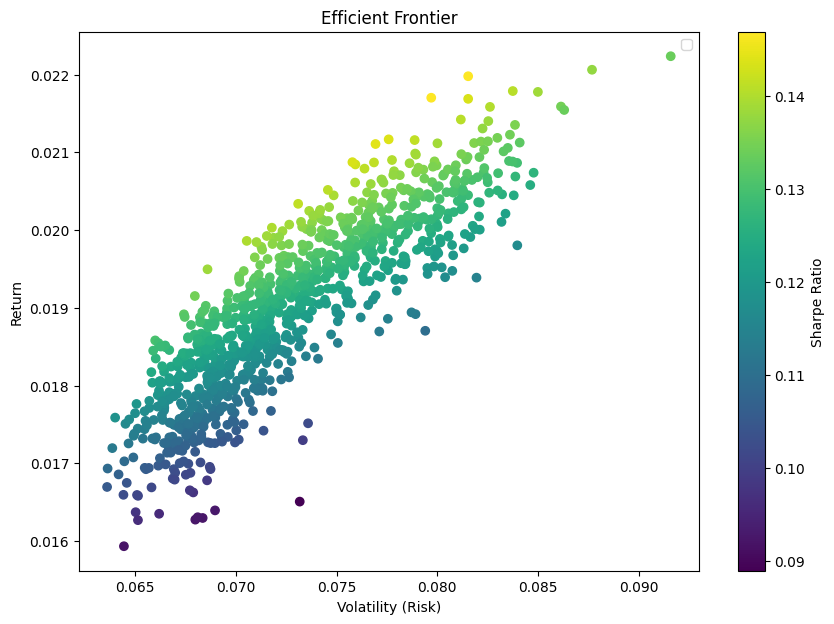

In [7]:
# Generate random portfolios for visualization (Efficient Frontier)
def generate_random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate=0.01):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    num_assets = len(mean_returns)

    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_return, portfolio_volatility, sharpe = portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)
        results[0, i] = portfolio_return
        results[1, i] = portfolio_volatility
        results[2, i] = sharpe

    return results, weights_record

# Generate random portfolios (for visualization)
num_portfolios = 1000
results, weights = generate_random_portfolios(num_portfolios, mean_returns, cov_matrix)

# Plot Efficient Frontier
plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.title('Efficient Frontier')
#plt.scatter(opt_volatility, opt_return, marker='*', color='r', s=500, label='Optimal Portfolio')
plt.legend(labelspacing=0.8)
plt.show()